# Feature extraction for training classifier model on pre-crisis prediction

The idea is to train a classification algorithm for identifying pre-crisis (stock market bubbles) and crisis periods that could annotate any kind of time series from the stock market. The hypothesis is that stock market works the same for any kind of company or index.

The goal in this notebook is to define features that could help the classification model to efficiently identify these periods. The assumption is that the information of the "moment" or the accumulated gradient of the residual values in a closed past could describe correctly the current situation of the event of "today" or the event to study.

This approach is without any doubt displaying a more complete picture than just considering the values of previous envents or the exponential decay of values from previous values.

Thus, it will be consider the previous historical stock market prices, this time series will be decomposed using the same frequency than for annotation (2 years) but the decomposition will be just one-sided, only considering past events. 

The features will be the residual value of the target day and the gradient with the residual values of 2, 4, 8, 16 and 32 months before (6 features to avoid overfitting taking into account that the size of the training data is pretty small).

The training and evaluation datasets will be built out of the S&P 500 index and the testing datasets will be a similar one, NYSE COMPOSITE (DJ) and a different one Nikkei 225 (Osaka) with crisis clearly occurring in different periods.

In [1]:
import sys
import datetime
from pandas.core import datetools
import pandas as pd
import numpy as np
sys.path.append("../..")
from src.helpers import time_series_decomposition, match_features_to_events, gradient_feature_calculation,\
                        build_feature_vector_from_time_series
from src.plotter import plot_time_series
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/Users/celsadiaz/.pyenv/versions/3.6.2/envs/ebroker/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


### Get testing time series from Yahoo Finance

In [2]:
# Download NYSE COMPOSITE (DJ) Index historical data
#yf.pdr_override()
#data = pdr.get_data_yahoo("^NYA", start="1967-01-01", end="2018-07-18")
#data.reset_index().to_csv('../../data/NYA_18.csv', index=False, encoding="utf-8")

# Download Nikkei 225 Index historical data
#yf.pdr_override()
#data = pdr.get_data_yahoo("^N225", start="1967-01-01", end="2018-07-18")
#data.reset_index().to_csv('../../data/N225_18.csv', index=False, encoding="utf-8")

### Load train and test datasets

In [3]:
# Load S&P 500 index time series (previously downloaded data for the annotation)
data_SP500 = pd.read_csv('../../data/S_and_P_500_50_18.csv')
data_SP500['date'] = data_SP500['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
data_SP500 = data_SP500.loc[:,('Date','date','Open')]

# Load NYA index time series
data_NYA = pd.read_csv('../../data/NYA_18.csv')
data_NYA['date'] = data_NYA['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
data_NYA = data_NYA.loc[:,('Date','date','Open')]

# Load N225 index time series
data_N225 = pd.read_csv('../../data/N225_18.csv')
data_N225['date'] = data_N225['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
data_N225 = data_N225.loc[:,('Date','date','Open')]

#### Decompose time series for train and test datasets

In [4]:
# Decomposition parameters
frequency = 2 * 365
log_scale = True
two_sided = False
plot = True
only_resid = True

col_time_series = 'Open'
col_label = 'label'
col_date = 'date'
x_time_col = 'Date'

# The features of the model will be the residual value for the given day and
# the gradient between that value and the residuals after 12 series of 2 months
month_period = [2,4,8,16,32]

# Features to scale for the model (mean = 0, std=1)
features_scale = ['residual', 'gradient_2', 'gradient_4', 'gradient_8', 'gradient_16', 'gradient_32']

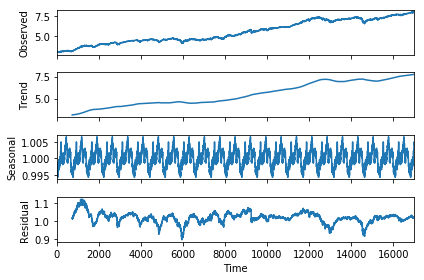

In [5]:
# Build feature vector for S&P 500
f_vector_SP500 = build_feature_vector_from_time_series(data_SP500, log_scale, frequency, two_sided, plot, only_resid, 
                                                       month_period, col_time_series, col_date, x_time_col, 
                                                       features_scale)

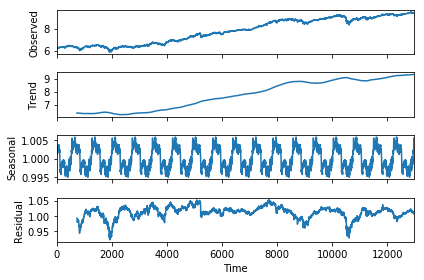

In [6]:
# Build feature vector for NYA
f_vector_NYA = build_feature_vector_from_time_series(data_NYA, log_scale, frequency, two_sided, plot, only_resid, 
                                                     month_period, col_time_series, col_date, x_time_col,
                                                     features_scale)
f_vector_NYA.to_csv("../../data/nya_test.csv", index=False, encoding='utf-8')

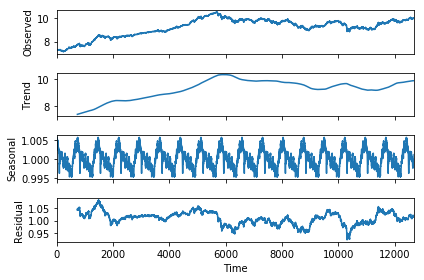

In [7]:
# Build feature vector for N225
f_vector_N225 = build_feature_vector_from_time_series(data_N225, log_scale, frequency, two_sided, plot, only_resid, 
                                                      month_period, col_time_series, col_date, x_time_col,
                                                      features_scale)
f_vector_N225.to_csv("../../data/n225_test.csv", index=False, encoding='utf-8')

## Build labeled train and test dataset for S&P 500 (training model set)

In [8]:
train_labeled_SP500 = pd.read_csv('../../data/training_correct_labeling.csv')
train_labeled_SP500 = train_labeled_SP500.dropna()

In [9]:
# match train set labels and split data in train and test sets
train_labels_SP500 = train_labeled_SP500.loc[:,(x_time_col, col_label)]
train_SP500 = f_vector_SP500.merge(train_labels_SP500, left_on=x_time_col, right_on=x_time_col)
train_set_dates = train_SP500[x_time_col].tolist()
test_SP500 = f_vector_SP500[~(f_vector_SP500[x_time_col].isin(train_set_dates))]

In [10]:
train_SP500.head(1)

,residual,gradient_2,gradient_4,gradient_8,gradient_16,gradient_32,Open,Date,label
0,1.745287,-2.81434,-1.137421,-1.30522,-0.786795,0.862505,45.93,1956-10-24,pre_crisis


In [11]:
train_SP500.tail(1)

,residual,gradient_2,gradient_4,gradient_8,gradient_16,gradient_32,Open,Date,label
12015,-0.219765,0.090867,-0.197037,0.405667,1.552255,1.205389,1093.880005,2004-07-22,standard


In [12]:
test_SP500.head(1)

,residual,gradient_2,gradient_4,gradient_8,gradient_16,gradient_32,Open,Date
13476,-0.216661,0.096976,-0.192597,0.408743,1.554477,1.207416,1096.839966,2004-07-23


In [13]:
test_SP500.tail(1)

,residual,gradient_2,gradient_4,gradient_8,gradient_16,gradient_32,Open,Date
16996,0.095722,-0.100599,-0.455151,-0.27624,0.120425,0.189852,2789.340088,2018-07-17


In [14]:
print("There are {} events in the training set and {} in the test.".format(len(train_SP500),len(test_SP500)))

There are 12016 events in the training set and 3521 in the test.


In [15]:
train_SP500.to_csv('../../data/train_crisis_annotation.csv', index=False, encoding='utf-8')
test_SP500.to_csv('../../data/test_crisis_annotation.csv', index=False, encoding='utf-8')